<a href="https://colab.research.google.com/github/BrianS99/License_Plate_CNN/blob/main/License_Plate_CNN_Good.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import numpy as np
import re
import random

from collections import Counter
from matplotlib import pyplot as plt
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow

In [2]:
random.random()

0.5754801431140075

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Put folder of manually labelled data below
MANUAL_LABEL_PATH = "/content/drive/MyDrive/ENPH 353/manual_label_pictures/"
manual_labels_raw = !ls "{MANUAL_LABEL_PATH}"
!ls "{MANUAL_LABEL_PATH}"
labels = manual_labels_raw[0].split()

0_012.jpg   4_2.jpg	 835.jpg      B_60.jpg	  I_190.jpg   Q_6.jpg
0_10.jpg    42.jpg	 8_37.jpg     B_6.jpg	  I_22.jpg    Q_8.jpg
0_122.jpg   4_33.jpg	 83.jpg       B6.jpg	  I_23.jpg    Q_9.jpg
0_123.jpg   43.jpg	 84.jpg       B7.jpg	  I_24.jpg    Q.jpg
0_133.jpg   47.jpg	 85.jpg       B_8.jpg	  I_2.jpg     R_10.jpg
0_144.jpg   49.jpg	 87.jpg       B8.jpg	  I_31.jpg    R_11.jpg
0_14.jpg    5_012.jpg	 88.jpg       B_new1.jpg  I_33.jpg    R_15.jpg
0_155.jpg   5_0193.jpg	 89.jpg       B_new2.jpg  J_15.jpg    R_1.jpg
0_17.jpg    5_120.jpg	 8BLBLB.jpg   B_new3.jpg  J_165.jpg   R_21.jpg
0_18.jpg    5_1222.jpg	 8DSLS.jpg    B_new5.jpg  J_1.jpg     R_24.jpg
0_1.jpg     5_12.jpg	 8FLFL.jpg    C_0.jpg	  J_22.jpg    R_31.jpg
01.jpg	    5_13.jpg	 8FPFPL.jpg   C_13.jpg	  J_25.jpg    S_124.jpg
0_24.jpg    5_145.jpg	 8GKG.jpg     C_1.jpg	  J_2.jpg     S_12.jpg
02.jpg	    5_155.jpg	 8HPHP.jpg    C_5.jpg	  J_3.jpg     S_141.jpg
0_31.jpg    5_15.jpg	 8LSLS.jpg    C_6.jpg	  J_4.jpg     S_1.jpg
04.jpg	    5

In [5]:
files_A1 = !ls "{MANUAL_LABEL_PATH}"
  # The files when listed from Google Drive have a particular format. They are
  # grouped in sets of 4 and have spaces and tabs as delimiters.
  
  # Split the string listing sets of 4 files by tab and space and remove any 
  # empty splits.
files_B1 = [list(filter(None, re.split('\t|\s', files))) for files in files_A1]
  
  # Concatenate all splits into a single sorted list
files1 = []
for element in files_B1:
  files1 = files1 + element
files1.sort()

# files
print(len(files1))

514


A function that encodes alphabet and numbers to 0-35

In [6]:
def char_to_num(char):
  # print(ord(char))
  if ord(char) >= 65 and ord(char) <= 90:
    return ord(char) - 65
  else:
    return ord(char) - 48 + 26

In [9]:
def ROS_manual_image_cropper(pathName, fileName):
  input_img = cv2.imread(pathName + "/" + fileName)
  gray_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
  return ([gray_img, char_to_num(fileName[0])],)

#Adding our own data generated from simulation

In [10]:
def create_manual_imgset(pathName, fileList):
  images = []
  for i in range(len(fileList)):
    imgs = ROS_manual_image_cropper(pathName, fileList[i])
    images += imgs
  return images

manual_imgset = create_manual_imgset(MANUAL_LABEL_PATH, files1)
imgset = manual_imgset

Displays a sample from the imported data set

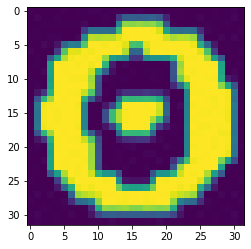

In [11]:
plt.imshow(imgset[0][0])

In [12]:
# Shuffle data set
np.random.shuffle(imgset)

print(imgset[2])

[array([[0, 0, 2, ..., 2, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [3, 1, 1, ..., 1, 1, 3],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 26]


In [13]:
# Genereate X and Y datasets
X_dataset_orig = np.array([data[0] for data in imgset[:]])
Y_dataset_orig = np.array([[data[1]] for data in imgset]).T


## Do One-Hot Encoding

In [14]:
NUMBER_OF_LABELS = 36
CONFIDENCE_THRESHOLD = 0.01

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y
  
# Normalize X (images) dataset
X_dataset_norm = X_dataset_orig/255.0
# X_dataset = np.squeeze(X_dataset_norm)
X_dataset = np.expand_dims(X_dataset_norm, axis=-1)

# Convert Y dataset to one-hot encoding
Y_dataset = convert_to_one_hot(Y_dataset_orig, NUMBER_OF_LABELS).T

In [15]:
X_dataset.shape

(514, 32, 32, 1)

In [16]:
VALIDATION_SPLIT = 0.2

print("Total examples: {:d}\nTraining examples: {:d}\nTest examples: {:d}".
      format(X_dataset.shape[0],
             math.ceil(X_dataset.shape[0] * (1-VALIDATION_SPLIT)),
             math.floor(X_dataset.shape[0] * VALIDATION_SPLIT)))
print("X shape: " + str(X_dataset.shape))
print("Y shape: " + str(Y_dataset.shape))

Total examples: 514
Training examples: 412
Test examples: 102
X shape: (514, 32, 32, 1)
Y shape: (514, 36)


## Train Neural Network

In [17]:
%tensorflow_version 1.14.0

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14.0`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [18]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend
from tensorflow.keras import losses
import tensorflow as tf

In [19]:
def reset_weights(model):
    session = backend.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

In [20]:
conv_model = models.Sequential()
conv_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                             input_shape=(32, 32, 1)))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Flatten())
conv_model.add(layers.Dropout(0.5))
conv_model.add(layers.Dense(512, activation='relu'))
conv_model.add(layers.Dense(36, activation='softmax'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [21]:
conv_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1

In [22]:
LEARNING_RATE = 1e-4
conv_model.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.RMSprop(lr=LEARNING_RATE),
                   metrics=['acc'])

In [23]:
reset_weights(conv_model)

In [24]:
history_conv = conv_model.fit(X_dataset, Y_dataset, 
                              validation_split=VALIDATION_SPLIT, 
                              epochs=80, 
                              batch_size=16)

Train on 411 samples, validate on 103 samples
Epoch 1/80
411/411 [==============================] - 4s 9ms/sample - loss: 3.4203 - acc: 0.0973 - val_loss: 3.2802 - val_acc: 0.1650
Epoch 2/80
411/411 [==============================] - 0s 517us/sample - loss: 3.1303 - acc: 0.1217 - val_loss: 3.0532 - val_acc: 0.0971
Epoch 3/80
411/411 [==============================] - 0s 498us/sample - loss: 2.8801 - acc: 0.1946 - val_loss: 2.7375 - val_acc: 0.2233
Epoch 4/80
411/411 [==============================] - 0s 491us/sample - loss: 2.5564 - acc: 0.2847 - val_loss: 2.3311 - val_acc: 0.3398
Epoch 5/80
411/411 [==============================] - 0s 501us/sample - loss: 2.1452 - acc: 0.4477 - val_loss: 1.8410 - val_acc: 0.5631
Epoch 6/80
411/411 [==============================] - 0s 487us/sample - loss: 1.7212 - acc: 0.6010 - val_loss: 1.4455 - val_acc: 0.6699
Epoch 7/80
411/411 [==============================] - 0s 500us/sample - loss: 1.3341 - acc: 0.6837 - val_loss: 1.0134 - val_acc: 0.7961
Epoc

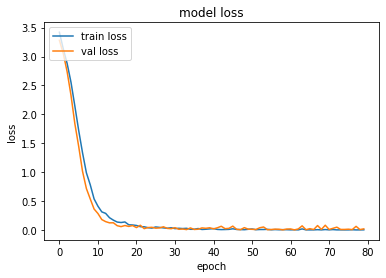

In [25]:
plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()

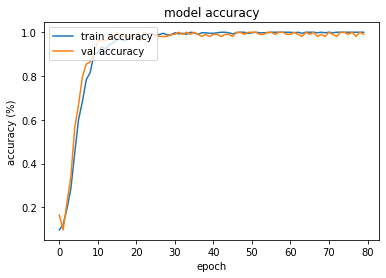

In [26]:
plt.plot(history_conv.history['acc'])
plt.plot(history_conv.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy (%)')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
plt.show()

## Test Model

Predicted Values Slider

In [31]:
# Display images in the training data set. 

def displayImage(index):
  img = X_dataset[index]
  
  img_aug = np.expand_dims(img, axis=0)
  y_predict = conv_model.predict(img_aug)[0]
  
  img_squeeze = np.squeeze(img, axis=-1)
  plt.imshow(img_squeeze)  
  caption = ("                  A  |  B  |  C  |  D  |  E  |  F  |  G  |  H  |  I  |  J  |  K  |  L  |  M  |  N  |  O  |  P  |  Q  |  R  |  S  |  T  |  U  |  V  |  W  |  X  |  Y  |  Z  |  0  |  1  |  2  |  3  |  4  |  5  |  6  |  7  |  8  |  9 \n"+
             "Predicted: {:.2} | {:.2} | {:.2} | {:.2} | {:.2} | {:.2} | {:.2} | {:.2} | {:.2} | {:.2} | {:.2} | {:.2} | {:.2} | {:.2} | {:.2} | {:.2} | {:.2} | {:.2} | {:.2} | {:.2} | {:.2} | {:.2} | {:.2} | {:.2} | {:.2} | {:.2} | {:.2} | {:.2} | {:.2} | {:.2} | {:.2} | {:.2} | {:.2} | {:.2} | {:.2} | {:.2}\n".
             format(y_predict[0],  y_predict[1],  y_predict[2],  y_predict[3],  y_predict[4],  y_predict[5],  y_predict[6],
                     y_predict[7],  y_predict[8],  y_predict[9],  y_predict[10],  y_predict[11],  y_predict[12],  y_predict[13],
                     y_predict[14],  y_predict[15],  y_predict[16],  y_predict[17],  y_predict[18],  y_predict[19],  y_predict[20],
                     y_predict[21],  y_predict[22],  y_predict[23],  y_predict[24],  y_predict[25],  y_predict[26],  y_predict[27],
                     y_predict[28],  y_predict[29],  y_predict[30],  y_predict[31],  y_predict[32],  y_predict[33],  y_predict[34],  y_predict[35]))
  plt.text(0.5, 0.5, caption, 
           color='orange', fontsize = 16,
           horizontalalignment='left', verticalalignment='bottom')


interact(displayImage, 
        index=ipywidgets.IntSlider(min=0, max=X_dataset_orig.shape[0],
                                   step=1, value=10))
#displayImage(3)

interactive(children=(IntSlider(value=10, description='index', max=514), Output()), _dom_classes=('widget-inte…

<function __main__.displayImage>

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
conv_model.save('saved_model/my_model3')

## Confusion Matrix

In [32]:
def num_to_char(num):
    if num <= 25:
        return chr(ord('A')+num)
    else:
        return chr(ord('0')+num-26)

vecs = []
for i in range(5):
  vecs += num_to_char(i)

print(vecs)

['A', 'B', 'C', 'D', 'E']


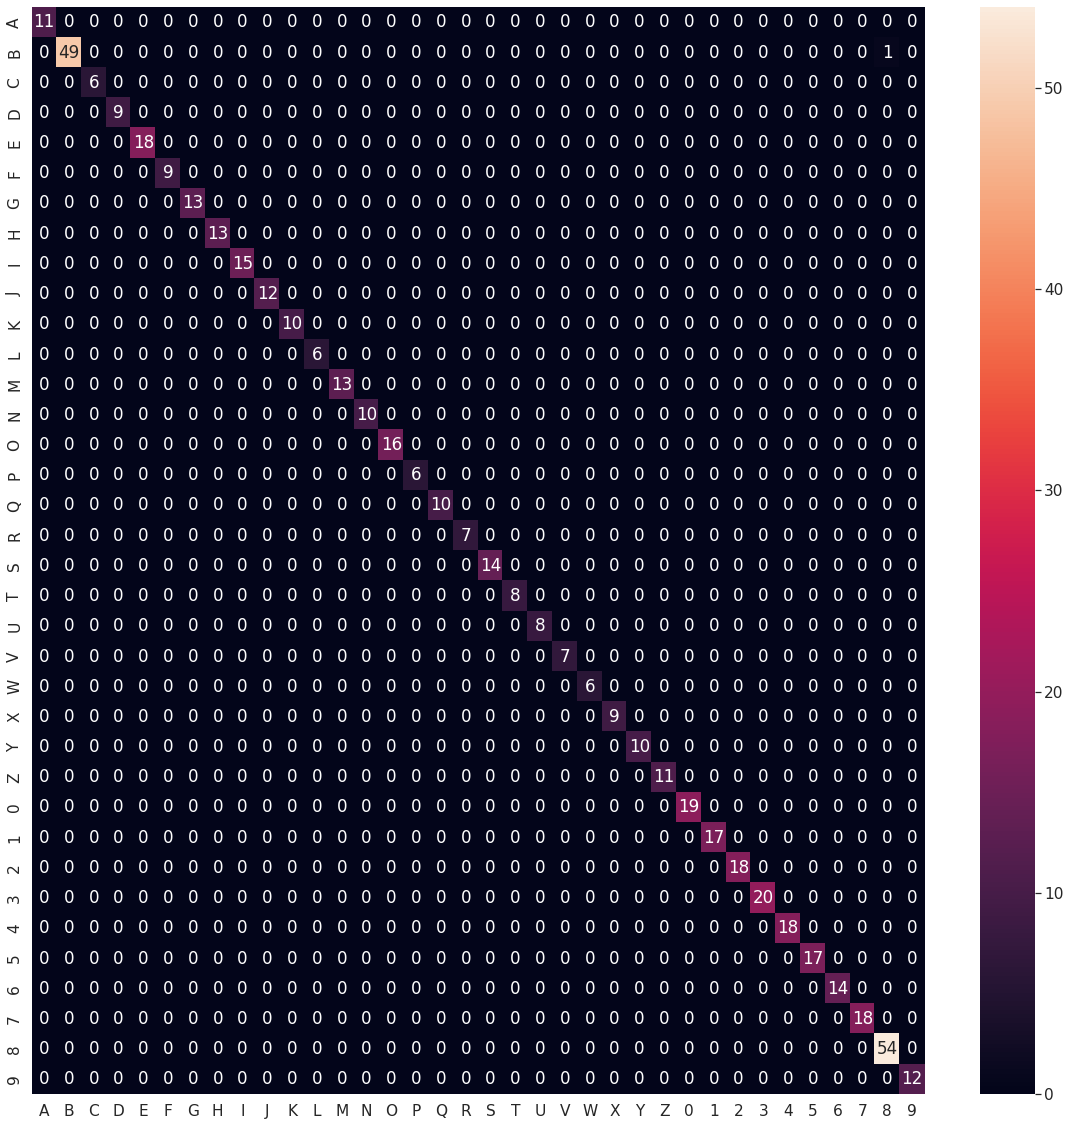

In [33]:
#On original data
y_pred = conv_model.predict(X_dataset)
y_predict = np.argmax(y_pred, axis=1)
y_test = np.argmax(Y_dataset, axis=1)

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

vecLabels = []
for i in range(36):
  vecLabels += num_to_char(i)

matrix = confusion_matrix(y_test, y_predict)
df_cm = pd.DataFrame(matrix, vecLabels, vecLabels)
plt.figure(figsize=(20,20))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True)

plt.show()